# Neural networks pruning
State-of-the-art neural networks nowadays have become extremely parameterized in order to maximize the prediction accuracy. However, the model also becomes costly to run and the inference latency becomes a bottleneck. On resource-constrained edge devices, the model has a lot of restrictions and cannot be parameterized as much as we can.

Sparse neural networks could perform as good as dense neural network with respect to the prediction accuracy, and the inference latency becomes much lower theoretically due to its small model size.

Neural network pruning is a method to create sparse neural networks from pre-trained dense neural networks. It is the process of deleting parameters from an existing neural network, which might involve removing individual parameters or groups of parameters.

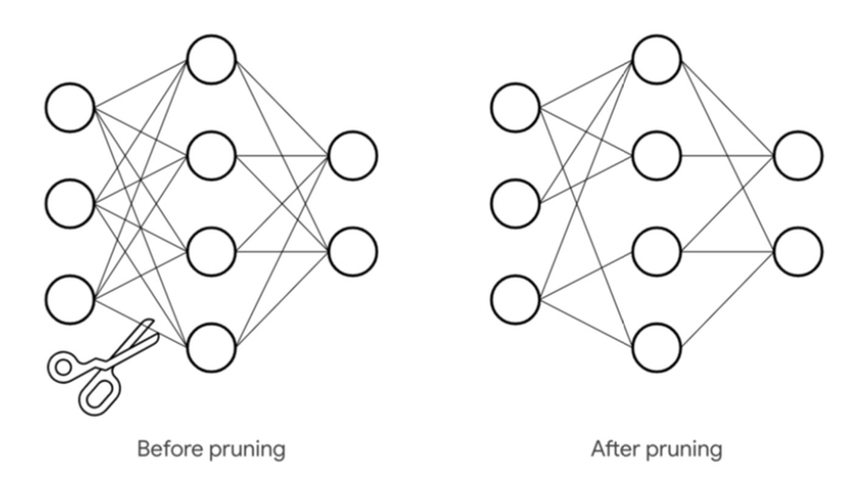

Today, we'll use PyTorch bultin prunning tools. Note, that there are a lot of other tools you can use for this purpose (for example last week's OpenVINO). Use this link for PyTorch prunning reference and documentation: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

First, import nessessery libraries.

In [ ]:
import torch
import time
import numpy as np
import tqdm

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation
from typing import Union, List, Tuple, Any
from abc import ABC, abstractmethod
import torch.nn.functional as F

Let's start with pretrained model. As usual, we'll use simple CNN model (like in Laboratory 3) and MNIST dataset. Don't use sequential blocks!

Train model for 5 epochs - you should get around ~98% accuracy.

Name the final trained model `CNN_MNIST`.

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, input_shape, num_of_cls) -> None:
        super().__init__()
        ch_in = input_shape[0]
        self.conv1 = nn.Conv2d(ch_in,32,3,padding=(1,1)) # shape [32,28,28]
        self.conv2 = nn.Conv2d(32,64,3,padding=(1,1)) # shape [64,14,14]
        self.conv3 = nn.Conv2d(64,128,3) # shape [128,5,5]

        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)

        self.classification_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, num_of_cls),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.batch1(self.conv1(x))), (2,2))
        x = F.max_pool2d(F.relu(self.batch2(self.conv2(x))), (2,2))
        x = F.relu(self.batch3(self.conv3(x)))
        y = self.classification_head(x)
        return y

torch_device = ...

train_dataset = ...
test_dataset = ...

train_loader = ...
test_loader = ...

CNN_MNIST = CNN(...)
metric = ...
loss_fcn = ...
optimizer = ...

def train_test_pass():
  ...

def training():
  ...

CNN_MNIST, history = training( ... )

Now, we can start our prunning. First...

# Unstructured Pruning
When talking about the cost of neural networks, the count of parameters is surely one of the most widely used metrics, along with FLOPS (floating-point operations per second). It is indeed intimidating to see networks displaying astronomical amounts of weights (up to billions for some), often correlated with stellar performance. Therefore, it is quite intuitive to aim at reducing directly this count by removing parameters themselves.

Directly pruning parameters has many advantages. First, it is simple, since replacing the value of their weight with zero, within the parameter tensors, is enough to prune a connection. Moreover it is easy to do without hurting the performance of the network. As pruning weights is not limited by any constraint at all and is the finest way to prune a network, such a paradigm is called **unstructured pruning**.

Let's start with simplest case - random unstructured pruning!

First - create net model `CNN_MNIST_RND` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform random unstructured prunning for 25% of all weights.

To do that, use `prune.random_unstructured()` function.
- The network layer is passed as the first argument to the function (you can get ti with `model.layer_name`;
- `name` identifies the parameter within that module using its string identifier - we update `weight`
-  and `amount` indicates the percentage of connections to prune (a float between 0. and 1.)

In [ ]:
CNN_MNIST_RND = CNN( ... )
optimizer_RND = ...
CNN_MNIST_RND.load_state_dict( ... )
optimizer_RND.load_state_dict( ... )

prune.random_unstructured(..., name=..., amount=...) # for 1st convolutional layer
... # for 2nd convolutional layer
... # for 3rd convolutional layer

Did it work? Let's find out!

First - evaluate both `CNN_MNIST_RND` and `CNN_MNIST` networks on testing dataset and print the accuracies. Compare it.

Then, calculate the sparsity for `CNN_MNIST_RND` model with following function.

Finally, compare `model.layer_name.weight` atributes for both networks for selected layer. Are some weights zeroed?

In [ ]:
#TODO: evaluate both models
... = train_test_pass(CNN_MNIST, ... )
... = train_test_pass(CNN_MNIST_RND, ... )

#TODO: print accuracy
print( ... )

#TODO: print sparsity
print(
     "Sparsity in CNN_MNIST_RND: {:.2f}%".format(
         100. * float(torch.sum(CNN_MNIST_RND.conv1.weight == 0)
                      + #the same for 2nd convolution
                      + #the same for 3rd convolution
                      )
         / float(CNN_MNIST_RND.conv1.weight.nelement()
                      + #the same for 2nd convolution
                      + #the same for 3rd convolution
                      )
    )
)

#TODO: print model.layer_name.weight for both networks
print( ... )
print( ... )

Well, prunning random weights is simple but unefficient. A real challenge in pruning is determining what to prune. If you are removing weights or nodes from a model, you want the parameters you remove to be less useful. There are different heuristics and methods of determining which nodes are less important and can be removed with minimal effect on accuracy.

For that, we can use L1 norm to find the smallest (least important) parameters.

First - create net model `CNN_MNIST_L1` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L1 unstructured prunning for 25% of all weights.

To do that, replace `prune.random_unstructured()` with `prune.l1_unstructured()` function. Evaluate the new network, calculate its sparsity and compare it's weights.

In [ ]:
CNN_MNIST_L1 = ...
optimizer_L1 = ...
...
...

prune.l1_unstructured( ... )
...
...
#TODO: evaluate model
...

#TODO: print accuracy
...

#TODO: print sparsity
...

#TODO: print  model.layer_name.weight for CNN_MNIST and CNN_MNIST_L1 networks
...

The sparsity of `CNN_MNIST_L1` and `CNN_MNIST_RND` should be the same, but the accuracy for L1 prunning should be much better!

If it's not, you got lucky! Try to rerun random prunning :)

# Structured Prining

Unstructured pruning results in a sparse neural network, which, while lower in terms of parameter count, may not be configured in a way that promotes speed improvements. Zeroing out the parameters saves memory but may not necessarily improve computing performance because we end up conducting the same number of matrix multiplications as before. To make use of technology and software that is specialized for dense processing, **structured pruning** algorithms consider parameters in groups, deleting entire neurons, filters, or channels.

For Convolutional Neural Networks, the most Hardware-efficient method is deleting entire channels. This operation can be very damaging for network accuracy, so we'll use L2 norm to calculate magnitude of each channel.

First - create net model `CNN_MNIST_STRUCT` and load trained weigts to it, with `load_state_dict` function.

Then, for each Convolutional Layer of this network, perform L2 structured prunning for 1/8 of all weights.

To do that, replace `prune.random_unstructured()` with `prune.ln_structured()` function. Whis fucntion, exept of layer, `name` and `amonut` takes two additional parameters:
- `n` which defines the Ln norm type, so we use `n=2`
- `dim` which defines the index of the dim along which we define channels to prune. the 0th axis corresponds to the output channels of the convolutional layer, so we use `dim=0`.

Evaluate the new network, calculate its sparsity and compare it's weights.




In [ ]:
CNN_MNIST_STRUCT = ...
optimizer_STRUCT = ...
...
...

prune.ln_structured( ... )
...
...

#TODO: evaluate model
...

#TODO: print accuracy
...

#TODO: print sparsity
...

#TODO: print model.layer_name.weight for CNN_MNIST and CNN_MNIST_STRUCT networks
...

How does the Structured Prunning impact the final network? Is it similar to traditional pruning?

One final approach we'll disguss is called:

# Iterative pruning

The ideal is to:
1. Train a neural network up to certain level of performance
2. Prune some of the weights / channels of the network
3. Train the pruned network for a few epochs
4. Repeat steps 2 and 3 untill acceptable performance

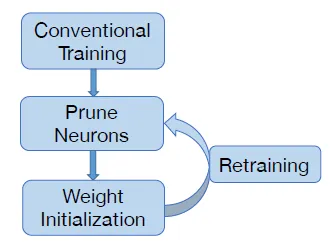

As your final task, create another model `CNN_MNIST_FNC` and `prune_and_train()` function where interactive prunning is implemented.

Then, run this function for 10 iterations with 10% random prunning for each iteration.

Finally, create the plot with accuracy as x-axis and sparsity as y-axis.

In [ ]:
CNN_MNIST_FNC = ...
...
...
...

In [ ]:
def prune_and_train(model: torch.nn.Module,
                    train_generator,
                    test_generator,
                    criterion,
                    metric: BaseMetic,
                    optimizer: torch.optim.Optimizer = None,
                    step: float = 0.1,
                    device = torch.device('cpu')):

    #TODO: Perform random prunning with amount of step

    #TODO: Calculate sparsity

    #TODO: Train for 1 epoch with train_generator

    #TODO: Evaluate with test_generator

    return model, loss_post_train, acc_post_train, sparsity


In [ ]:
for i in range(10):
    CNN_MNIST_FNC, loss, acc, sparsity = prune_and_train(CNN_MNIST_FNC, ... )
    #TODO: Prepare data for plot

#TODO: Plot

**Extention exercise**

Update the function with `prunning_mode` parameter that takes string `random` , `l1` or `structured` and perform tests of accuracy to sparsity ratio for each type of prunning. Plot the results.  

In [ ]:
...